In [35]:
from transformers import pipeline
from langdetect import detect
from nltk.corpus import stopwords
import nltk, re, json, matplotlib.pyplot as plt

In [36]:
nltk.download('stopwords')

model_es = "finiteautomata/beto-sentiment-analysis"
model_en = "cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_es = pipeline("sentiment-analysis", model=model_es)
sentiment_en = pipeline("sentiment-analysis", model=model_en)

stopwords_es = stopwords.words('spanish')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santenana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Device set to use cuda:0
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [37]:
def clean_text(text, lang):
    text = re.sub(r"[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ\s]", "", text)
    words = text.lower().split()
    if lang == "es":
        words = [w for w in words if w not in stopwords_es]
    else:
        words = [w for w in words if w not in stopwords_en]
    return " ".join(words)

In [38]:
gratitude_words = {
    "es": ["gracias", "excelente", "genial", "amable", "perfecto", "satisfecho"],
    "en": ["thank", "great", "nice", "appreciate", "awesome", "helpful", "love"]
}


In [39]:
def detect_gratitude(text, lang):
    found = [w for w in gratitude_words.get(lang, []) if w in text.lower()]
    return found

In [40]:
def sentiment_pipeline(text):
    lang = detect(text)
    print(f"🗣️ Idioma detectado: {lang}")
    cleaned = clean_text(text, lang)
    gratitude = detect_gratitude(cleaned, lang)
    if lang == "es":
        sent = sentiment_es(cleaned)[0]
    else:

        sent = sentiment_en(cleaned)[0]
    print(f"\nTexto limpio: {cleaned}")
    print(f"Gratitud detectada: {gratitude}")
    print(f"Sentimiento: {sent['label']} ({sent['score']:.2f})")
    labels = ["positive", "neutral", "negative"]
    scores = [0, 0, 0]
    label_map = {
        "LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2": "positive",
        "NEG": "negative", "NEU": "neutral", "POS": "positive"
    }
    label = label_map.get(sent['label'], sent['label'])
    if label == "positive": scores[0] = sent['score']
    elif label == "neutral": scores[1] = sent['score']
    else: scores[2] = sent['score']

    plt.bar(labels, scores, color=["green", "gray", "red"])
    plt.title(f"Probabilidad de Sentimiento ({lang.upper()})")
    plt.ylabel("Probabilidad")
    plt.show()

    return {
        "idioma": lang,
        "texto_limpio": cleaned,
        "gratitud": gratitude,
        "sentimiento": sent
    }

In [41]:
from transformers import pipeline, WhisperProcessor, WhisperForConditionalGeneration
import torch
import librosa
OUTPUT_DIR = './whisper-finetuned-transcipt-es'
def transcribe_audio(audio_path, processor=None, model=None, device=None):
    """
    Transcribe audio usando el modelo Whisper fine-tuned
    """
    if processor is None or model is None:
        processor, model, device = load_whisper_model()
    
    print(f"🎧 Procesando audio: {audio_path}")
    

    audio, sampling_rate = librosa.load(audio_path, sr=16000)
    
    input_features = processor(
        audio, 
        sampling_rate=16000, 
        return_tensors="pt").input_features.to(device)

    with torch.no_grad():
        predicted_ids = model.generate(input_features)

    transcription = processor.batch_decode(
        predicted_ids, 
        skip_special_tokens=True)[0]
    
    return transcription

def load_whisper_model(model_path=OUTPUT_DIR):
    """
    Carga el modelo Whisper fine-tuned y el procesador
    """
    print(f"📥 Cargando modelo Whisper desde {model_path}...")
    processor = WhisperProcessor.from_pretrained(model_path)
    model = WhisperForConditionalGeneration.from_pretrained(model_path)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    print(f"✅ Modelo cargado en {device}")
    
    return processor, model, device

def analyze_sentiment_multilang(text):
    lang = detect_language(text)
    emotion_classifier = pipeline(
        "text-classification",
        model="SamLowe/roberta-base-go_emotions",
        top_k=5  
    )

    if lang == 'es':
        sentiment_model = "Hate-speech-CNERG/dehatebert-mono-spanish"
    elif lang == 'en':
        sentiment_model = "cardiffnlp/twitter-roberta-base-offensive"
    else:
        sentiment_model = "nlptown/bert-base-multilingual-uncased-sentiment"
    
    sentiment_classifier = pipeline(
        "sentiment-analysis",
        model=sentiment_model
    )
    
    emotions = emotion_classifier(text)[0]
    sentiment = sentiment_classifier(text)[0]
    
    return {
        "language": lang,
        "text": text,
        "emotions": emotions,
        "sentiment": sentiment,
        "alert_level": calculate_alert_level(emotions)
    }
def detect_language(text):
    """
    Detecta automáticamente el idioma del texto
    """
    try:
        lang = detect(text)
        return lang
    except:
        return 'en' 

In [45]:
OUTPUT_DIR = './whisper-finetuned-transcipt-es'
processor, model, device = load_whisper_model(model_path=OUTPUT_DIR)

audio_path = '/home/santenana/Proyectos_ML_DC/03_Audio_to_Speech/test_5.wav'

text = transcribe_audio(audio_path, processor, model, device)
text

📥 Cargando modelo Whisper desde ./whisper-finetuned-transcipt-es...
✅ Modelo cargado en cuda
🎧 Procesando audio: /home/santenana/Proyectos_ML_DC/03_Audio_to_Speech/test_5.wav


'la gonorrea para que fue punta es que desde que te pute zapá y fue puta no menos así\xad o qué gonorrea'

In [ ]:
# text = 'Muchas gracias por tu ayuda, eres muy amable y excelente en lo que haces. ¡Te lo agradezco mucho!'

🗣️ Idioma detectado: es

Texto limpio: gonorrea punta pute zapá puta menos así gonorrea
Gratitud detectada: []
Sentimiento: NEG (0.98)


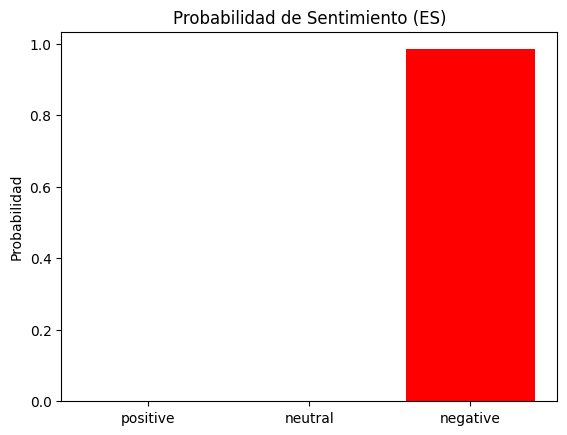

In [46]:
result = sentiment_pipeline(text)